In [14]:
import lr
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from livelossplot import PlotLossesKeras
import keras.datasets
from keras.utils import plot_model
from sklearn.model_selection import train_test_split
import math
from keras.src.optimizers import RMSprop
import matplotlib.pyplot as plt
from res.Import_Statements import outputColor
from termcolor import colored
from keras.src.losses import MeanAbsoluteError, MeanAbsolutePercentageError
from sklearn.preprocessing import MinMaxScaler

# Oefening 1: The Simpsons Revisited
We willen het geslacht van een Simpson kunnen voorspellen m.b.v. een neuraal netwerk (cfr. hoofdstuk
Beslissingsbomen uit Data Science 1). Deze dataset is erg klein en daarom kunnen we geen validatie-set
of test-set construeren.

In [2]:
# a) Lees de dataset ('The Simpsons original.csv) van de Simpsons in.
df = pd.read_csv('datasets/The Simpsons original.csv')
df.head()

,name,hair length,weight,age,gender
0,Homer,0,250,36,M
1,Marge,10,150,34,F
2,Bart,2,90,10,M
3,Lisa,6,78,8,F
4,Maggie,4,20,1,F


b) Wat voor soort voorspelling trachten we hier te doen? Regressie of classificatie?\
\
**Op basis van de beschrijving gaan we het geslacht voorspellen, wat een classificatieprobleem is.**

In [3]:
x_simpsons = df.drop(columns=['gender', 'name'])
y_simpsons = df['gender']

In [4]:
# d) Maak nu een input training data set x_simpsons en normaliseer deze (min-max normalisatie). Doe hetzelfde voor outputkolom y_simpsons

# Normalization functie
def minmax_norm(col):
    return (col - col.min()) / (col.max() - col.min())


# Normaliseer de input features
x_simpsons = x_simpsons.apply(minmax_norm, axis=0)

# Convert target variable to numeric if necessary
y_simpsons = y_simpsons.map({'M': 1, 'F': 0})

# Handle any missing values in the target variable
x_simpsons = x_simpsons[y_simpsons.notna()]
y_simpsons = y_simpsons.dropna()

x_train_cer, x_test_cer, y_train_cer, y_test_cer = train_test_split(x_simpsons, y_simpsons, test_size=0.2,
                                                                    random_state=42)

accuracy
	training         	 (min:    0.800, max:    0.800, cur:    0.800)
	validation       	 (min:    0.000, max:    0.000, cur:    0.000)
Loss
	training         	 (min:    0.520, max:    0.521, cur:    0.520)
	validation       	 (min:    1.236, max:    1.243, cur:    1.243)
1/1 [==============================] - 0s 213ms/step - loss: 0.5200 - accuracy: 0.8000 - val_loss: 1.2432 - val_accuracy: 0.0000e+00


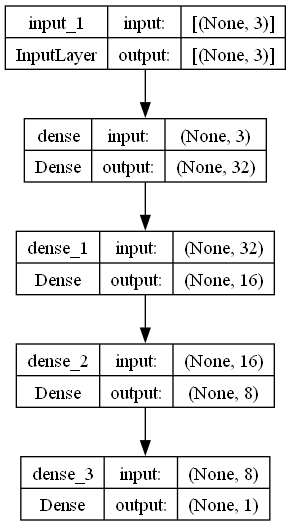

In [5]:
# e) Maak een neuraal netwerk met de correcte inputs en outputs. Maak een plot van het ANN.
input_simpsons = Input(shape=(x_simpsons.shape[1],))
x_simpsons_nn = Dense(32, activation='sigmoid')(input_simpsons)
x_simpsons_nn = Dense(16, activation='sigmoid')(x_simpsons_nn)
x_simpsons_nn = Dense(8, activation='sigmoid')(x_simpsons_nn)
output_simpsons_nn = Dense(1, activation='sigmoid')(x_simpsons_nn)

# Create the model
model_simpsons = Model(inputs=input_simpsons, outputs=output_simpsons_nn, name="SimpsonsGenderClassifier")
model_simpsons.summary()

# Compile the model
model_simpsons.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_simpsons = model_simpsons.fit(x_train_cer, y_train_cer, epochs=50, validation_split=0.2,
                                      callbacks=[PlotLossesKeras()])
# history_simpsons = model_simpsons.fit(x_simpsons, y_simpsons, epochs=100, batch_size=32, verbose=1)

# Plot
plot_model(model_simpsons, show_shapes=True, to_file='model_simpsons.png', show_layer_names=True)

In [6]:
model_simpsons.summary()

Model: "SimpsonsGenderClassifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense (Dense)               (None, 32)                128       
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 801 (3.13 KB)
Trainable params: 801 (3.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [7]:
# f) Use the neural network to predict the gender
# Predict the gender for the entire dataset
predicted = model_simpsons.predict(x_simpsons).flatten()
predicted = np.where(predicted > 0.5, 'M', 'F')
original = y_simpsons.map({1: 'M', 0: 'F'}).values

# Calculate the accuracy
correct_predictions = np.sum(predicted == original)
total_predictions = len(original)
accuracy_percentage = (correct_predictions / total_predictions) * 100

print(f"Predicted values: {predicted}")
print(f"Original values: {original}")
print(f"Accuracy: {accuracy_percentage:.2f}%")

# Compare predicted and actual values for the test set
predicted_test = model_simpsons.predict(x_test_cer).flatten()
predicted_test = np.where(predicted_test > 0.5, 'M', 'F')
comparison = pd.DataFrame(
    {'Actual': y_test_cer.map({1: 'M', 0: 'F'}).reset_index(drop=True), 'Predicted': predicted_test})
print(comparison)

# Calculate test set accuracy
correct_predictions_test = np.sum(predicted_test == comparison['Actual'])
total_predictions_test = len(comparison)
accuracy_percentage_test = (correct_predictions_test / total_predictions_test) * 100

print(f"Test Set Accuracy: {accuracy_percentage_test:.2f}%")

# Predict the gender of the unknown Simpson
unknown_simpson = pd.DataFrame({'hair length': [8], 'weight': [500], 'age': [38]})
unknown_simpson = unknown_simpson.apply(minmax_norm, axis=0)
predicted_unknown = model_simpsons.predict(unknown_simpson)
predicted_unknown_gender = 'F' if predicted_unknown < 0.5 else 'M'
print(f"The predicted gender for the unknown Simpson is: {predicted_unknown_gender}")

1/1 [==============================] - 0s 74ms/step
Predicted values: ['M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M']
Original values: ['M' 'F' 'M' 'F' 'F' 'M' 'F' 'M' 'M']
Accuracy: 55.56%
1/1 [==============================] - 0s 25ms/step
  Actual Predicted
0      M         M
1      F         M
Test Set Accuracy: 50.00%
1/1 [==============================] - 0s 21ms/step
The predicted gender for the unknown Simpson is: M


# Oefening 2: Forecast demo Revisited
We willen de opbrengsten van een bedrijf per kwartaal van de laatste 5 jaar kunnen voorspellen (cfr.
hoofdstuk Forecasting uit Data Science 1). Deze dataset is erg klein en daarom kunnen we geen
validatie-set of test-set construeren.

Loss
	loss             	 (min:   86.791, max:  160.091, cur:   86.791)
mean_absolute_percentage_error
	mean_absolute_percentage_error 	 (min:   71.940, max:  131.438, cur:  131.438)
1/1 [==============================] - 0s 45ms/step
Model: "Forecast_NN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_18 (Dense)            (None, 64)                192       
                                                                 
 dense_19 (Dense)            (None, 64)                4160      
                                                                 
 dense_20 (Dense)            (None, 64)                4160      
                                                                 
 dense_21 (Dense)            (None, 1)                 65        
                   

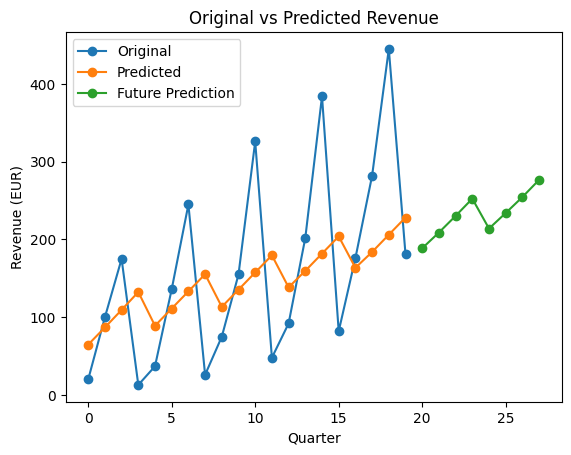

In [13]:
data = pd.read_csv('datasets/forcastdemo.csv', delimiter=';')

# Separate inputs and output
x_forecast = data[['Year', 'Quarter']]
y_forecast = data['Revenu']

# Define the input layer
inputs_forecast = Input(shape=(2,))

# Add hidden layers
x_forecast_model = Dense(64, activation='relu')(inputs_forecast)
x_forecast_model = Dense(64, activation='relu')(x_forecast_model)
x_forecast_model = Dense(64, activation='relu')(x_forecast_model)
# Define the output layer
outputs_forecast = Dense(1, activation='linear')(x_forecast_model)

# Create the model
model_forecast = Model(inputs_forecast, outputs_forecast, name='Forecast_NN')

# Compile the model
model_forecast.compile(optimizer=Adam(learning_rate=0.001),
                       loss=keras.losses.MeanAbsoluteError(),
                       metrics=[keras.metrics.MeanAbsolutePercentageError()])

# Train the model
history_forecast = model_forecast.fit(
    x_forecast,
    y_forecast,
    epochs=100,
    callbacks=[PlotLossesKeras()],  # Plot the losses
    verbose=False
)

# Predict using the model
predictions = model_forecast.predict(x_forecast)

model_forecast.summary()
model_forecast.evaluate(x_forecast, y_forecast)

# Use the model for prediction
predicted = model_forecast.predict(x_forecast)                                                                  
original = y_forecast.values                                                                                    

# Also attempt to predict the future. You know, just for fun :)
future = pd.DataFrame({'Year': [6, 6, 6, 6, 7, 7, 7, 7], 'Quarter': [1, 2, 3, 4, 1, 2, 3, 4]})
predicted_future = model_forecast.predict(future)                                                               

plt.figure()
plt.plot(range(0, len(data)), original, 'o-', label='Original')
plt.plot(range(0, len(data)), predicted[:, 0], 'o-', label='Predicted')
plt.plot(range(len(data), len(data) + len(future)), predicted_future, 'o-', label='Future Prediction')
plt.xlabel('Quarter')
plt.ylabel('Revenue (EUR)')
plt.title('Original vs Predicted Revenue')
plt.legend()
plt.show()

# Oefening 3

   sepal length  sepal width  petal length  petal width       target
0           5.1          3.5           1.4          0.2  Iris-setosa
1           4.9          3.0           1.4          0.2  Iris-setosa
2           4.7          3.2           1.3          0.2  Iris-setosa
3           4.6          3.1           1.5          0.2  Iris-setosa
4           5.0          3.6           1.4          0.2  Iris-setosa
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal length  150 non-null    float64
 1   sepal width   150 non-null    float64
 2   petal length  150 non-null    float64
 3   petal width   150 non-null    float64
 4   target        150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB
None
       sepal length  sepal width  petal length  petal width
count    150.000000   150.000000    150.000000   150.000000
mean

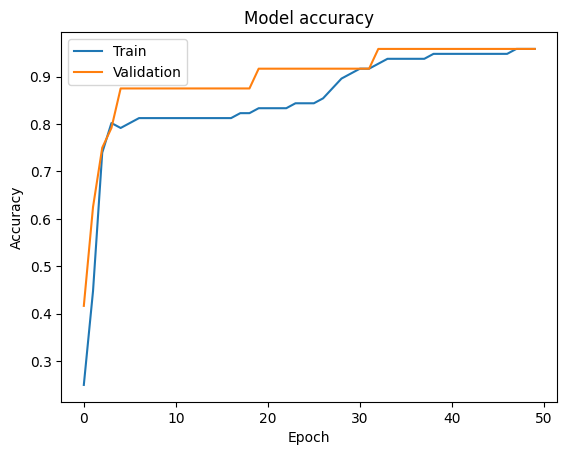

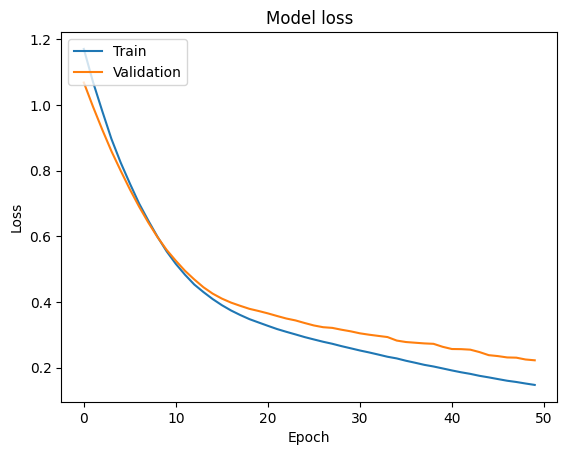

In [17]:
from sklearn.preprocessing import StandardScaler
from keras import Sequential

iris = pd.read_csv('datasets/iris.csv')
print(iris.head())
print(iris.info())
print(iris.describe())

# Dit is een classificatie probleem.

# We gebruiken alle kolommen behalve 'target' voor voorspelling.
x_iris = iris.drop(columns=['target'])

# Normaliseer de data
scaler = StandardScaler()
x_iris_normalized = scaler.fit_transform(x_iris)

# Zet de target om naar numerieke waarden
y_iris = iris['target']
y_iris_encoded = pd.get_dummies(y_iris).values

# Splits de data in training en test sets
x_train_iris, x_test_iris, y_train_iris, y_test_iris = train_test_split(x_iris_normalized, y_iris_encoded, test_size=0.2, random_state=42)

# Maak een neuraal netwerk met de correcte inputs en outputs.
model = Sequential([
    Dense(64, activation='relu', input_shape=(x_train_iris.shape[1],)),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])

# Compileer het model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train het model
history = model.fit(x_train_iris, y_train_iris, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Evalueer je neuraal netwerk op de test data set
loss, accuracy = model.evaluate(x_test_iris, y_test_iris, verbose=1)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [18]:
# Nieuwe bloemvoorspelling
def predict_new_flower(model, scaler, new_data):
    # Normaliseer de nieuwe data met dezelfde scaler
    new_data_normalized = scaler.transform([new_data])
    # Maak een voorspelling
    prediction = model.predict(new_data_normalized)
    # Decodeer de voorspelling
    classes = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
    predicted_class = classes[np.argmax(prediction)]
    return predicted_class

# Voorbeeld van nieuwe bloemdata: sepal length, sepal width, petal length, petal width
new_flower = [5.1, 3.3, 1.7, 0.5]
predicted_class = predict_new_flower(model, scaler, new_flower)
print(f'Predicted class for the new flower: {predicted_class}')

1/1 [==============================] - 0s 57ms/step
Predicted class for the new flower: Iris-setosa
